# Navier-Stokes simulation in 2D
Currently only the simulation of a pressure driven lid is possible. This can be extended by adding more possibilities to the function 'set_BC'.

Iteration number: 1


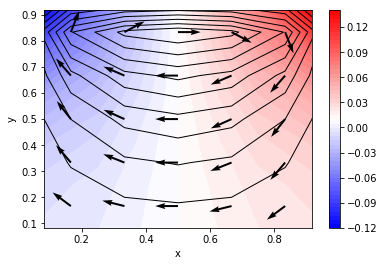

Iteration number: 50


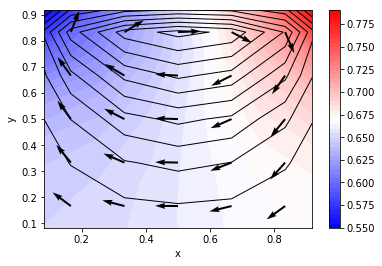

Iteration number: 100


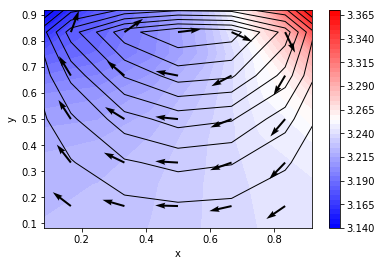

Iteration number: 150


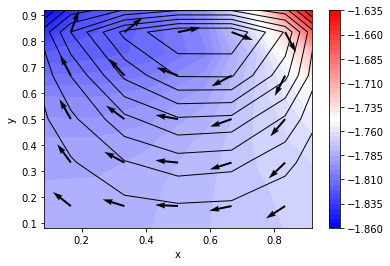

Iteration number: 200


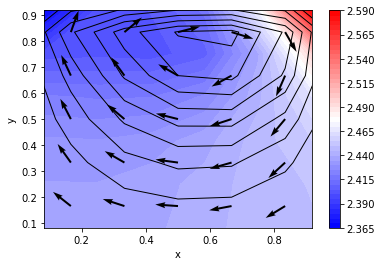

Iteration number: 250


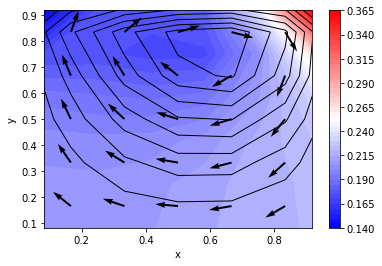

Iteration number: 300


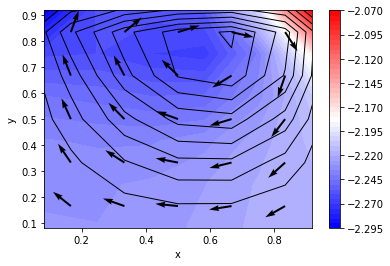

Iteration number: 350


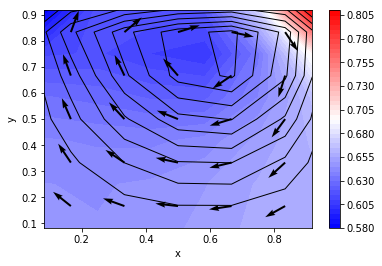

Iteration number: 400


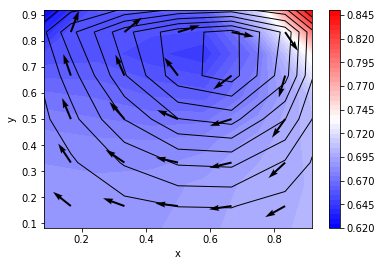

Iteration number: 400


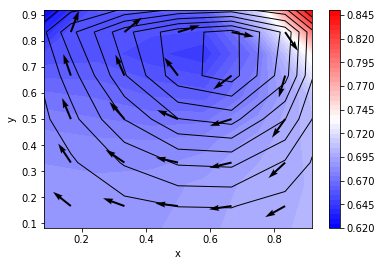

Maximum number of iterations (400) has been reached.
Runtime 4.38 s


In [453]:
#%matplotlib notebook
import time
import numpy as np
import scipy as sci

from types import SimpleNamespace

from functions import *
from constants import *
from simulation import *

start_time = time.time()

# Initial conditions 
const = SimpleNamespace()

const.Re = 1e2      # Reynolds number
const.dt = 1e-2     # time step
const.tf = 4e0      # final time
const.nx = 6       # number of x-gridpoints
const.ny = 6       # number of y-gridpoints
const.nsteps = 10   # step interval for graphic output
const.lx = 1        # width of box
const.ly = 1        # height of box
    
const.rho_arrow = 20 # Density of arrows in quiver plot per unit length l

## Set other constants (incl. grid) which are determined by initial conditions specified above
const = constants(const)

# IC's
data = SimpleNamespace()
data = initialisation(const, data)

# BC's
## North, East, South, West
bc = SimpleNamespace()
bc = set_BC(const, bc, 'lid')

# Boundary matrices
const.Ubc , const.Vbc = set_BM(const, bc) # Maybe change const. to bc.

# Operator matrices on P, U, V, Q respectively
LP = SimpleNamespace()
LP = laplacian(const, LP)
LP = cholesky_decomposition(LP)

# Simulation
simulation_data = simulation(const, bc, LP, data)

end_time = time.time()
print('Runtime', np.round(end_time - start_time,2), 's')

# Preliminary object function

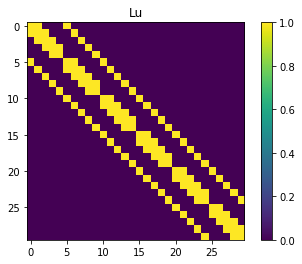

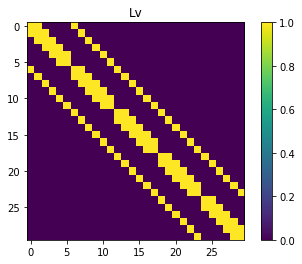

In [461]:
visualise_matrix(LP.Lu!=0, 'Lu')
visualise_matrix(LP.Lv!=0, 'Lv')

In [462]:
obj.coord_U[0] = 3
obj.coord_U[1] = 4

obj.coord_V[0] = 3
obj.coord_V[1] = 4


def laplace_repl_U(const, LP, obj):

    lp_row = (const.nx-1) + 1
    lu_row = (const.nx-1) + 1
    lv_row = const.nx + 1
    
    x_factor = (const.dt / const.Re)/const.hx**2
    y_factor = (const.dt / const.Re)/const.hy**2   


    # Object in Lp
    

    # Object in Lu
    obj_col = obj.coord_U[0]
    obj_row = obj.coord_U[1]

    m_start = obj_row*lu_row
    
    obj_n = m_start+obj_col
    obj_m = m_start+obj_col
    
    ## E and W element
    LP.Lu[obj_n-1, obj_m-1] = LP.Lu[obj_n-1, obj_m-1] - x_factor
    LP.Lu[obj_n+1, obj_m+1] = LP.Lu[obj_n+1, obj_m+1] - x_factor
    ## S and N element
    LP.Lu[obj_n-lu_row, obj_m-lu_row] = LP.Lu[obj_n-lu_row, obj_m-lu_row] - y_factor
    LP.Lu[obj_n+lu_row, obj_m+lu_row] = LP.Lu[obj_n+lu_row, obj_m+lu_row] - y_factor    
    
    # Object in Lv
    obj_col = obj.coord_V[0]
    obj_row = obj.coord_V[1]

    m_start = obj_row*lv_row
    
    obj_n = m_start+obj_col
    obj_m = m_start+obj_col
    
    ## E and W element
    LP.Lu[obj_n-1, obj_m-1] = LP.Lu[obj_n-1, obj_m-1] - y_factor
    LP.Lu[obj_n+1, obj_m+1] = LP.Lu[obj_n+1, obj_m+1] - y_factor
    ## S and N element
    LP.Lu[obj_n-lv_row, obj_m-lv_row] = LP.Lu[obj_n-lv_row, obj_m-lv_row] - x_factor
    LP.Lu[obj_n+lv_row, obj_m+lv_row] = LP.Lu[obj_n+lv_row, obj_m+lv_row] - x_factor
    
    


In [469]:
# Circular object
scale = 1/2
R = const.lx*scale/2
cx, cy = const.lx/3, const.ly/2

# Object for a centered grid
## Should have shape (nx, ny)
indices_cgrid = ((const.X_ave-cx)**2 + (const.Y_ave-cy)**2 <= R**2).T

# Translate to P, U and V grid 
indices_Pgrid = np.zeros((const.nx, const.ny), dtype=float)
indices_Ugrid = np.zeros((const.nx-1, const.ny), dtype=float)
indices_Vgrid = np.zeros((const.nx, const.ny-1), dtype=float)

indices_Pgrid[:,:] = indices_cgrid

indices_Ugrid[:,:] = (indices_Pgrid[:-1,:] + np.roll(indices_Pgrid[:-1,:], -1, axis = 0) ) > 0
indices_Ugrid[:,:] = (indices_Ugrid[:,:] + \
                      np.roll(indices_Ugrid[:,:], -1, axis = 1) + \
                      np.roll(indices_Ugrid[:,:], 1, axis = 1)) > 0
                                 
indices_Vgrid[:,:] = (indices_Pgrid[:,:-1] + np.roll(indices_Pgrid[:,:-1], -1, axis = 1) ) > 0
indices_Vgrid[:,:] = (indices_Vgrid[:,:] + \
                      np.roll(indices_Vgrid[:,:], -1, axis = 0) + \
                      np.roll(indices_Vgrid[:,:], 1, axis = 0)) > 0

obj = SimpleNamespace()

obj.coord_P = np.where(indices_Pgrid == np.max(indices_Pgrid))
obj.coord_U = np.where(indices_Ugrid == np.max(indices_Ugrid))
obj.coord_V = np.where(indices_Vgrid == np.max(indices_Vgrid))


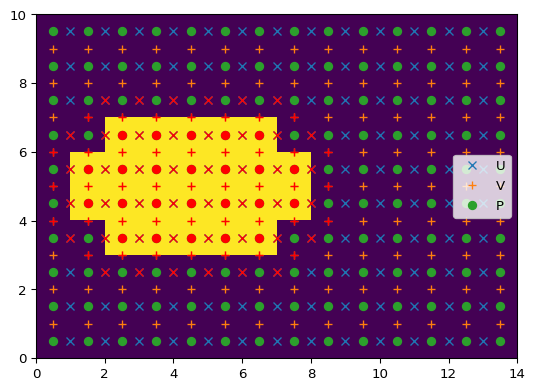

In [352]:
import numpy as np
import matplotlib.pyplot as plt

x0 = 0
xL = const.nx

y0 = 0
yL = const.ny

Obj = indices_Pgrid

u_x = np.arange(x0+1, xL, 1)
u_y = np.arange(y0+0.5, yL+0.5, 1)
[X_u, Y_u] = np.meshgrid(u_x, u_y)

v_x = np.arange(x0+0.5, xL+0.5, 1)
v_y = np.arange(y0+1, yL, 1)
[X_v, Y_v] = np.meshgrid(v_x, v_y)

p_x = np.arange(x0+0.5, xL + 0.5, 1)
p_y = np.arange(y0+0.5, yL + 0.5, 1)
[X_p, Y_p] = np.meshgrid(p_x, p_y)

my_dpi = 96
plt.figure(figsize=(xL*40/my_dpi, yL*40/my_dpi), dpi=my_dpi)
plt.plot(np.reshape(X_u, (-1,)), np.reshape(Y_u, (-1,)), 'x', label='U')
plt.plot(np.reshape(X_v, (-1,)), np.reshape(Y_v, (-1,)), '+', label='V')
plt.plot(np.reshape(X_p, (-1,)), np.reshape(Y_p, (-1,)), 'o', label='P')

plt.plot(objcoord_P[0] + 0.5, objcoord_P[1] + 0.5, 'or')
plt.plot(objcoord_U[0] + 1, objcoord_U[1] + 0.5, 'xr')
plt.plot(objcoord_V[0] + 0.5, objcoord_V[1] + 1, '+r')

plt.legend()
plt.imshow(Obj.T, extent=[x0, xL, y0, yL])
plt.tight_layout()
plt.show()



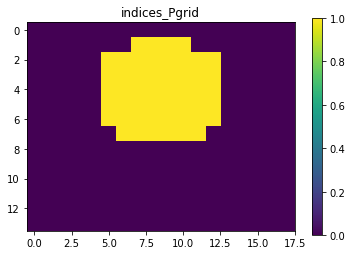

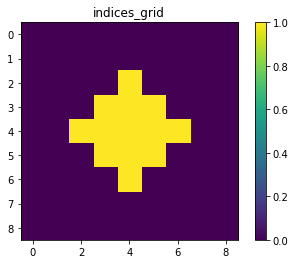

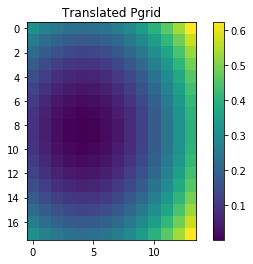

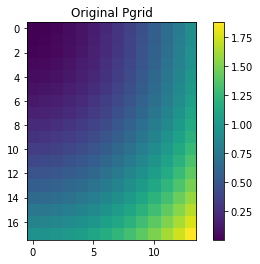

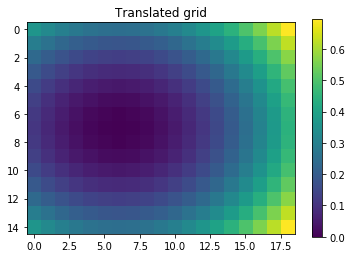

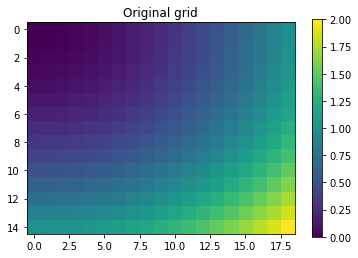

In [345]:
# Visual check of object
'''
indices_Pgrid = indices_Pgrid*1
indices_Pgrid[6,8] = 10
indices_Pgrid[6,7] = 20

indices_Pgrid[10,20] = 10
indices_Pgrid[9,20] = 20
'''
visualise_matrix(indices_Pgrid,'indices_Pgrid')
visualise_matrix(indices_grid,'indices_grid')

# Visual representation of grid
visualise_matrix((const.X_ave-cx)**2 + (const.Y_ave-cy)**2,'Translated Pgrid')
visualise_matrix((const.X_ave)**2 + (const.Y_ave)**2,'Original Pgrid')

visualise_matrix((const.X-cx)**2 + (const.Y-cy)**2,'Translated grid')
visualise_matrix((const.X)**2 + (const.Y)**2,'Original grid')

In [115]:
indices_Ugrid = np.zeros((np.shape(data.U)), dtype=bool)
indices_Vgrid = np.zeros((np.shape(data.V)), dtype=bool)

# Firstly shape[1] as this is the x-coordinate and shape[0] secondly as this is the y-coordinate
# range starts at 1 in order to prevent looking to non-existent elements. (Here it is okay to start from 1 for both x and y as the object is not at the boundary of the domain)
for x in range(1, np.shape(indices_Pgrid)[1]):
    for y in range(1, np.shape(indices_Pgrid)[0]):
        if indices_Pgrid[y,x]:
            if indices_Pgrid[y, x-1]:
                indices_Ugrid[y, x] = True
            if indices_Pgrid[y+1, x]:
                indices_Vgrid[y, x] = True # Indices kloppen hier nog niet
#visualise_matrix(indices_Pgrid, 'Pgrid')
#visualise_matrix(indices_Ugrid, 'Ugrid')
#visualise_matrix(indices_Vgrid, 'Vgrid')